In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../..")

import logging
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from xlstm_scaling_laws.analysis.isoflop.data import create_filtered_isoflop_data_table
from xlstm_scaling_laws.common.load_data import load_run_data, load_run_summary_table
from xlstm_scaling_laws.common.wandb_run_data import download_wandb_run_data_per_tag
from xlstm_scaling_laws.load_data import create_isoflop_data_table
from xlstm_scaling_laws.load_data.isoflop import add_isoflop_columns
from xlstm_scaling_laws.run_data import RunData

logging.basicConfig(level=logging.FATAL, format="%(levelname)s: %(message)s")
from plot_config import savefig

# IsoFLOP profile with 1e+20 FLOPs

In [2]:
isoflop_raw_run_data_df = create_isoflop_data_table(
    data_specifier="isoflop_mlstm_ctx8192",
)

In [3]:
isoflop_df = create_filtered_isoflop_data_table(
    data_specifier="isoflop_mlstm_ctx8192",
)

In [4]:
isoflop_large_bs_df = create_filtered_isoflop_data_table(
    data_specifier="isoflop_mlstm_ctx8192_large_gbs256",
)

In [5]:
def get_batch_size_plot(figsize=(8, 6), ms=50):
    isoflop_raw_run_data_df = create_isoflop_data_table(
        data_specifier="isoflop_mlstm_ctx8192",
    )
    isoflop_df = create_filtered_isoflop_data_table(
        data_specifier="isoflop_mlstm_ctx8192",
    )
    isoflop_large_bs_df = create_filtered_isoflop_data_table(
        data_specifier="isoflop_mlstm_ctx8192_large_gbs256",
    )

    fig, (ax_left, ax_right) = plt.subplots(
        nrows=1, ncols=2, figsize=figsize, gridspec_kw={"wspace": 0.25}
    )
    df = isoflop_raw_run_data_df
    df = df[df["IsoFLOP"].isin(["3e+19", "1e+20"])]
    df.rename(columns={"global_batch_size": "Batch Size"}, inplace=True)
    df["Batch Size"] = df["Batch Size"].astype(int)
    ax = sns.scatterplot(
        data=df,
        x="num_params",
        y="val/.dclm_loss",
        hue="IsoFLOP",
        style="Batch Size",
        markers=True,
        s=ms,  # Add this parameter to control marker size
        # palette=sns.color_palette(
        #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
        # ), #sns.color_palette("deep"),
        palette=sns.color_palette("deep"),
        ax=ax_left,
    )
    # ax = sns.scatterplot(
    #         data=isoflop_large_bs_df,
    #         x="num_params_calculated",
    #         y="val/.dclm_loss",
    #         hue="IsoFLOP",
    #         style="learning_rate",
    #         markers=True,
    #         # palette=sns.color_palette(
    #         #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
    #         # ), #sns.color_palette("deep"),
    #     )
    ax.set_xscale("log")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=0.5)
    ax.set_ylim(2.3, 3.4)
    ax.set_xlim(1e8, 1e10)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend().remove()

    # Try to make the batch size more visible
    df = pd.concat([isoflop_df, isoflop_large_bs_df], axis=0)
    df = df[df["IsoFLOP"].isin(["1e+20"])]
    df = df.rename(columns={"global_batch_size": "Batch Size"}).reset_index(drop=True)
    df["Batch Size"] = df["Batch Size"].astype(int)
    ax = sns.scatterplot(
        data=df,
        x="num_params",
        y="val/.dclm_loss",
        hue="IsoFLOP",
        style="Batch Size",
        markers=True,
        s=ms,  # Add this parameter to control marker size
        palette=sns.color_palette("deep")[1:2],  # Only use one color for IsoFLOP=1e+20
        # palette=sns.color_palette(
        #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
        # ), #sns.color_palette("deep"),
    )
    # ax = sns.scatterplot(
    #         data=isoflop_large_bs_df,
    #         x="num_params",
    #         y="val/.dclm_loss",
    #         hue="IsoFLOP",
    #         style="global_batch_size",
    #         markers=True,
    #         # palette=sns.color_palette(
    #         #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
    #         # ), #sns.color_palette("deep"),
    #     )
    ax.set_xscale("log")
    ax.legend().remove()
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(alpha=0.5)
    ax.set_ylim(2.3, 3.5)
    # ax.set_xlim(1e9, 1e12)
    xlim = (1e8, 3e9)
    xticks = [1e8, 4e8, 1e9, 2e9, 4e9]
    xtick_labels = ["100M", "400M", "1B", "2B", "4B"]
    axes = (ax_left, ax_right)
    for ax in axes:
        ax.set_xlabel("Model Parameters")
        ax.set_ylabel("Validation Loss")
        ax.set_xscale("log")
        ax.grid(which="both")
        ax.grid(which="minor", linestyle="-", linewidth=0.5, color="lightgrey")
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)
        ax.set_ylim(2.6, 3.2)
        ax.set_xlim(xlim)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xtick_labels)

    # Create figure legend
    fig.legend(
        handles, labels, loc="upper right", bbox_to_anchor=(1.07, 0.91), markerscale=1.2
    )

    return fig

/tmp/ipykernel_222286/924455090.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"global_batch_size": "Batch Size"}, inplace=True)
/tmp/ipykernel_222286/924455090.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Batch Size"] = df["Batch Size"].astype(int)
/tmp/ipykernel_222286/924455090.py:17: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.scatterplot(


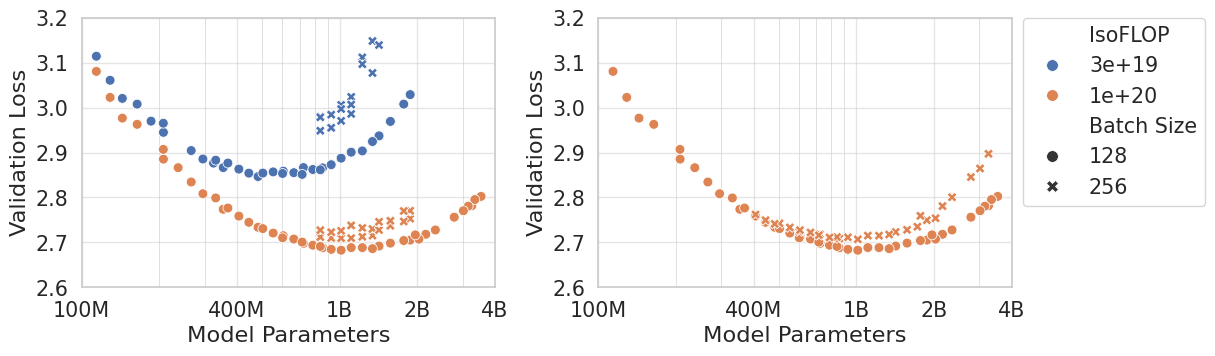

In [6]:
with sns.plotting_context("notebook", font_scale=1.35):
    with sns.axes_style("whitegrid"):
        fig = get_batch_size_plot(figsize=(12, 3.5))

In [7]:
savefig(fig, "isoflop_batch_size_exp_plot")

/tmp/ipykernel_222286/1243595668.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"global_batch_size": "Batch Size"}, inplace=True)


(100000000.0, 10000000000.0)

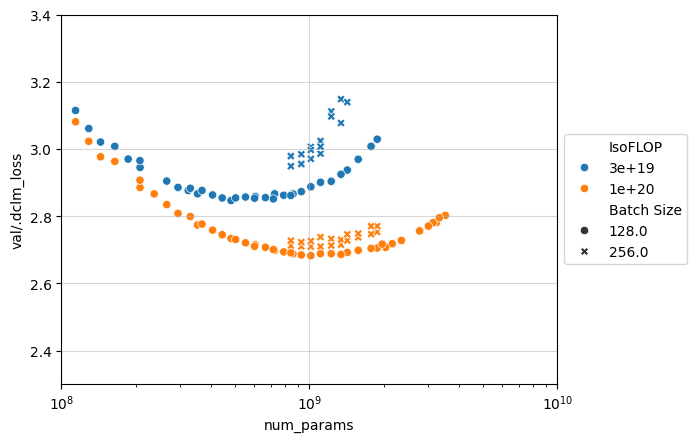

In [8]:
# Visualize steps
df = isoflop_raw_run_data_df
df = df[df["IsoFLOP"].isin(["3e+19", "1e+20"])]
df.rename(columns={"global_batch_size": "Batch Size"}, inplace=True)

ax = sns.scatterplot(
    data=df,
    x="num_params",
    y="val/.dclm_loss",
    hue="IsoFLOP",
    style="Batch Size",
    markers=True,
    # palette=sns.color_palette(
    #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
    # ), #sns.color_palette("deep"),
)
# ax = sns.scatterplot(
#         data=isoflop_large_bs_df,
#         x="num_params_calculated",
#         y="val/.dclm_loss",
#         hue="IsoFLOP",
#         style="learning_rate",
#         markers=True,
#         # palette=sns.color_palette(
#         #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
#         # ), #sns.color_palette("deep"),
#     )
ax.set_xscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.5)
ax.set_ylim(2.3, 3.4)
ax.set_xlim(1e8, 1e10)

In [9]:
df

,name,run_tag,model_type,Batch Size,learning_rate,context_length,num_params,num_params_calculated,num_train_steps,num_lr_warmup_steps,...,proj_factor_ffn,num_heads,proj_factor_qk,chunk_size,vocab_size,ffn_multiple_of,status,IsoFLOP,Preset Token Param Ratio,Preset Num Params
2,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps57500_n...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,128.0,0.003,8192,1.140347e+08,1.140347e+08,57500.0,750.0,...,2.667,5,0.5,64,50304,64,finished,3e+19,550,<130M
3,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps192000_...,"nb10_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,128.0,0.003,8192,1.140347e+08,1.140347e+08,192000.0,750.0,...,2.667,5,0.5,64,50304,64,finished,1e+20,extra,<130M
6,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps48500_n...,"nb13_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,128.0,0.003,8192,1.289281e+08,1.289281e+08,48500.0,750.0,...,2.667,5,0.5,64,50304,64,finished,3e+19,extra,<130M
7,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps162000_...,"nb13_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,128.0,0.003,8192,1.289281e+08,1.289281e+08,162000.0,750.0,...,2.667,5,0.5,64,50304,64,finished,1e+20,extra,<130M
10,dclm_mLSTMv1_100M_ctx8192_lr0.003_steps42000_n...,"nb16_ed640_nh5_pf2.667,sclaw_iso",mlstm_v1,128.0,0.003,8192,1.438216e+08,1.438216e+08,42000.0,750.0,...,2.667,5,0.5,64,50304,64,finished,3e+19,extra,<180M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,dclm_mLSTMv1_2.7B_ctx8192_lr0.002_steps6000_nb...,sclaw_iso_round6,mlstm_v1,128.0,0.002,8192,2.781269e+09,2.781269e+09,6000.0,750.0,...,2.667,10,0.5,64,50304,64,finished,1e+20,extra,<1.4B
218,dclm_mLSTMv1_1.8B_ctx8192_lr0.002_steps7000_nb...,sclaw_iso_round6,mlstm_v1,128.0,0.002,8192,2.350131e+09,2.350131e+09,7000.0,750.0,...,2.667,9,0.5,64,50304,64,finished,1e+20,extra,<1.4B
219,dclm_mLSTMv1_1.8B_ctx8192_lr0.002_steps7800_nb...,sclaw_iso_round6,mlstm_v1,128.0,0.002,8192,2.157556e+09,2.157556e+09,7800.0,750.0,...,2.667,9,0.5,64,50304,64,finished,1e+20,extra,<1.4B
220,dclm_mLSTMv1_1.4B_ctx8192_lr0.002_steps8200_nb...,sclaw_iso_round6,mlstm_v1,128.0,0.002,8192,2.028825e+09,2.028825e+09,8200.0,750.0,...,2.667,8,0.5,64,50304,64,finished,1e+20,extra,<1.4B


(2.3, 3.5)

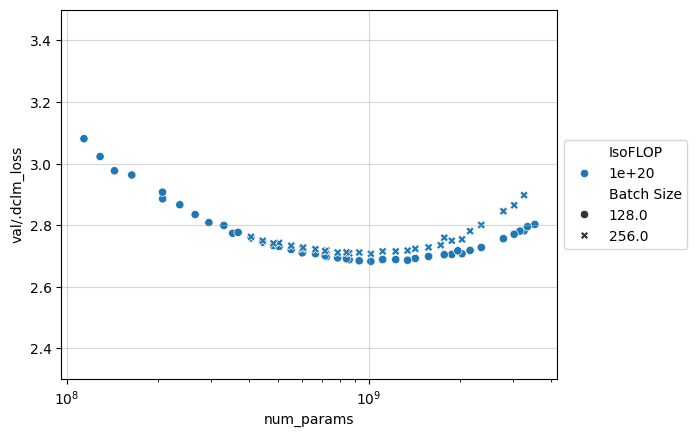

In [10]:
# Try to make the batch size more visible
df = pd.concat([isoflop_df, isoflop_large_bs_df], axis=0)
df = df[df["IsoFLOP"].isin(["1e+20"])]
df = df.rename(columns={"global_batch_size": "Batch Size"}).reset_index(drop=True)
ax = sns.scatterplot(
    data=df,
    x="num_params",
    y="val/.dclm_loss",
    hue="IsoFLOP",
    style="Batch Size",
    markers=True,
    # palette=sns.color_palette(
    #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
    # ), #sns.color_palette("deep"),
)
# ax = sns.scatterplot(
#         data=isoflop_large_bs_df,
#         x="num_params",
#         y="val/.dclm_loss",
#         hue="IsoFLOP",
#         style="global_batch_size",
#         markers=True,
#         # palette=sns.color_palette(
#         #     "rocket_r", n_colors=len(data_df["Model Size"].unique())
#         # ), #sns.color_palette("deep"),
#     )
ax.set_xscale("log")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.grid(alpha=0.5)
ax.set_ylim(2.3, 3.5)
# ax.set_xlim(1e9, 1e12)

In [11]:
with sns.plotting_context("notebook", font_scale=1.35):
    with sns.axes_style("whitegrid"):
        pass